In [29]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plotty
import missingno as msno
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
# suppress ugly warning messages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
# Lambdas
days_since = lambda x: x - df.time_stamp.min()
remove_whitespace = lambda x: x.replace(" ", "")
# log = lambda x: np.log(x)

# Data Preparation

In [30]:
# price_paid               int64 [233500, 270000, 176000, 450000, 440000]
# money, possibly look into normalizing
# deed_date               object ['05/07/2017', '05/07/2017', '05/07/2017', '05/07/2017', '05/07/2017']
# date object convert to timestamp and then add days since value
# property_type           object ['F', 'T', 'O', 'S', 'D']
# categorical data perform label encoder
# new_build               object ['N', 'Y']
# categorical data perform label encoder
# estate_type             object ['L', 'F']
# categorical data perform label encoder
# district                object ['TOWER HAMLETS', 'CITY OF LONDON', 'HACKNEY', 'HARROW', 'WALTHAM FOREST']
# categorical data perform label encoder
# transaction_category    object ['A', 'B']
# categorical data perform label encoder

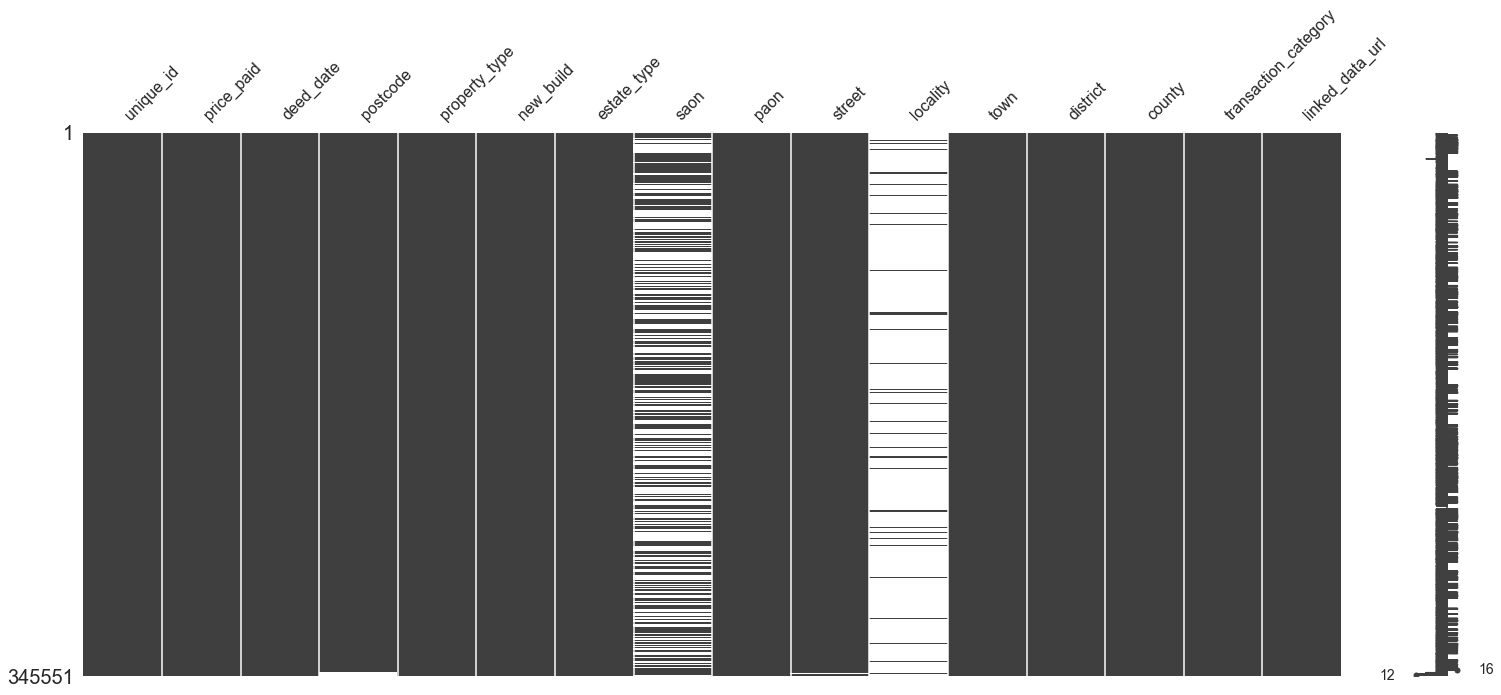

In [37]:
# Load the datasets
pricing_df = pd.read_csv('../data/raw/01_06_2014_until_04_06_2019.csv')
# We can load the 1gb master csv of postcode data into memory with pandas
postcode_df = pd.read_csv('../data/raw/NSPL_MAY_2019_UK.csv', low_memory=False)
msno.matrix(pricing_df)

In [32]:
pricing_df.postcode = pricing_df.postcode.astype(str).map(remove_whitespace)
postcode_df.pcd = postcode_df.pcd.astype(str).map(remove_whitespace)

In [33]:
# Merging the datasets to bring in lat and lon values.
left = pricing_df
right = postcode_df
df = pd.merge(left, right, how='left', left_on='postcode', right_on='pcd')
# Drop the rows that have NaN in lat or long column
df = df.dropna(subset=['lat'])
df = df.dropna(subset=['long'])
df.shape

(343135, 57)

In [34]:
# Split by Boroughs of interest
lewisham = df.loc[df['district'] == 'LEWISHAM']
croydon = df.loc[df['district'] == 'CROYDON']
kensington_chelsea = df.loc[df['district'] == 'KENSINGTON AND CHELSEA']
westminster = df.loc[df['district'] == 'CITY OF WESTMINSTER']

In [35]:
# Check for duplicate values
df.duplicated().any()

False

In [36]:
df = westminster
# remove property type other
df = df.loc[df['property_type'] != 'O']
# Remove outliers in price
df = df.loc[(df['price_paid'] < (1000000)) & (df['price_paid'] > (10000))]
# Convert the date object type to... timestamp
df['time_stamp'] = pd.to_datetime(df['deed_date'])
# Create features for year and month
df['year'] = df['time_stamp'].dt.year
df['month'] = df['time_stamp'].dt.month
# apply the lambda on time_stamp, writing to new column
df['days_since'] = df['time_stamp'].map(days_since)
# encode the 'days since' and write to new column
df['days_since'] = df['days_since'].dt.days
# Setting the index to timestamp for time series operations
df.index = df['time_stamp']
# Dropping unnecessary column
df.drop(['time_stamp'], axis=1)
# round to the nearest thousand £
df['price_paid'] = df['price_paid'].round(decimals=3)
# df.drop(['unique_id', 'paon', 'saon', 'linked_data_url', 'street', 'locality', 'county', 'town', 'postcode'], axis=1)
df['property_type_encoded'] = df[['property_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['new_build_encoded'] = df[['new_build']].apply(preprocessing.LabelEncoder().fit_transform)
df['estate_type_encoded'] = df[['estate_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['transaction_category_encoded'] = df[['transaction_category']].apply(preprocessing.LabelEncoder().fit_transform)
# Selecting columns for modelling
df = df[['price_paid', 'lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']]
westminster_prep = df.sample(2500,random_state=1)
corr = westminster_prep.corr()
corr.style.background_gradient(cmap='coolwarm')

,price_paid,lat,long,year,month,days_since,property_type_encoded,new_build_encoded,estate_type_encoded,transaction_category_encoded
price_paid,1,-0.11434,0.133803,0.0150551,-0.00128626,0.0145818,0.0800805,0.154205,-0.0661666,-0.142236
lat,-0.11434,1,-0.718712,-0.0232656,-0.0103212,-0.0261538,0.0808319,-0.0552383,-0.112354,0.0429092
long,0.133803,-0.718712,1,0.00593273,0.00156453,0.00633316,-0.190251,0.152365,0.207772,0.00876663
year,0.0150551,-0.0232656,0.00593273,1,-0.154427,0.978707,0.00184959,-0.0583648,-0.00610555,0.0670028
month,-0.00128626,-0.0103212,0.00156453,-0.154427,1,0.0509347,0.00348206,0.0153022,0.00774457,0.0332019
days_since,0.0145818,-0.0261538,0.00633316,0.978707,0.0509347,1,0.00257737,-0.0559517,-0.00488002,0.0749051
property_type_encoded,0.0800805,0.0808319,-0.190251,0.00184959,0.00348206,0.00257737,1,-0.0529376,-0.802027,-0.00680784
new_build_encoded,0.154205,-0.0552383,0.152365,-0.0583648,0.0153022,-0.0559517,-0.0529376,1,0.0481974,0.00376083
estate_type_encoded,-0.0661666,-0.112354,0.207772,-0.00610555,0.00774457,-0.00488002,-0.802027,0.0481974,1,0.0269581
transaction_category_encoded,-0.142236,0.0429092,0.00876663,0.0670028,0.0332019,0.0749051,-0.00680784,0.00376083,0.0269581,1


In [9]:
df = kensington_chelsea
# remove property type other
df = df.loc[df['property_type'] != 'O']
# Remove outliers in price
df = df.loc[(df['price_paid'] < (1000000)) & (df['price_paid'] > (10000))]
# Convert the date object type to... timestamp
df['time_stamp'] = pd.to_datetime(df['deed_date'])
# Create features for year and month
df['year'] = df['time_stamp'].dt.year
df['month'] = df['time_stamp'].dt.month
# apply the lambda on time_stamp, writing to new column
df['days_since'] = df['time_stamp'].map(days_since)
# encode the 'days since' and write to new column
df['days_since'] = df['days_since'].dt.days
# Setting the index to timestamp for time series operations
df.index = df['time_stamp']
# Dropping unnecessary column
df.drop(['time_stamp'], axis=1)
# round to the nearest thousand £
df['price_paid'] = df['price_paid'].round(decimals=3)
# df.drop(['unique_id', 'paon', 'saon', 'linked_data_url', 'street', 'locality', 'county', 'town', 'postcode'], axis=1)
df['property_type_encoded'] = df[['property_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['new_build_encoded'] = df[['new_build']].apply(preprocessing.LabelEncoder().fit_transform)
df['estate_type_encoded'] = df[['estate_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['transaction_category_encoded'] = df[['transaction_category']].apply(preprocessing.LabelEncoder().fit_transform)
# Selecting columns for modelling
df = df[['price_paid', 'lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']]
kensington_chelsea_prep = df.sample(2500, random_state=1)
corr = kensington_chelsea_prep.corr()
corr.style.background_gradient(cmap='coolwarm')

(4193, 10)

In [10]:
df = croydon
# remove property type other
df = df.loc[df['property_type'] != 'O']
# Remove outliers in price
df = df.loc[(df['price_paid'] < (1000000)) & (df['price_paid'] > (10000))]
# Convert the date object type to... timestamp
df['time_stamp'] = pd.to_datetime(df['deed_date'])
# Create features for year and month
df['year'] = df['time_stamp'].dt.year
df['month'] = df['time_stamp'].dt.month
# apply the lambda on time_stamp, writing to new column
df['days_since'] = df['time_stamp'].map(days_since)
# encode the 'days since' and write to new column
df['days_since'] = df['days_since'].dt.days
# Setting the index to timestamp for time series operations
df.index = df['time_stamp']
# Dropping unnecessary column
df.drop(['time_stamp'], axis=1)
# round to the nearest thousand £
df['price_paid'] = df['price_paid'].round(decimals=3)
# df.drop(['unique_id', 'paon', 'saon', 'linked_data_url', 'street', 'locality', 'county', 'town', 'postcode'], axis=1)
df['property_type_encoded'] = df[['property_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['new_build_encoded'] = df[['new_build']].apply(preprocessing.LabelEncoder().fit_transform)
df['estate_type_encoded'] = df[['estate_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['transaction_category_encoded'] = df[['transaction_category']].apply(preprocessing.LabelEncoder().fit_transform)
# Selecting columns for modelling
df = df[['price_paid', 'lat','long','year','month','days_since', 'property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']]
croydon_prep = df.sample(2500, random_state=1)
corr = croydon_prep.corr()
corr.style.background_gradient(cmap='coolwarm')

(5237, 10)

In [11]:
df = lewisham
# remove property type other
df = df.loc[df['property_type'] != 'O']
# Remove outliers in price
df = df.loc[(df['price_paid'] < (1000000)) & (df['price_paid'] > (10000))]
# Convert the date object type to... timestamp
df['time_stamp'] = pd.to_datetime(df['deed_date'])
# Create features for year and month
df['year'] = df['time_stamp'].dt.year
df['month'] = df['time_stamp'].dt.month
# apply the lambda on time_stamp, writing to new column
df['days_since'] = df['time_stamp'].map(days_since)
# encode the 'days since' and write to new column
df['days_since'] = df['days_since'].dt.days
# Setting the index to timestamp for time series operations
df.index = df['time_stamp']
# Dropping unnecessary column
df.drop(['time_stamp'], axis=1)
# round to the nearest thousand £
df['price_paid'] = df['price_paid'].round(decimals=3)
# df.drop(['unique_id', 'paon', 'saon', 'linked_data_url', 'street', 'locality', 'county', 'town', 'postcode'], axis=1)
df['property_type_encoded'] = df[['property_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['new_build_encoded'] = df[['new_build']].apply(preprocessing.LabelEncoder().fit_transform)
df['estate_type_encoded'] = df[['estate_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['transaction_category_encoded'] = df[['transaction_category']].apply(preprocessing.LabelEncoder().fit_transform)
# Selecting columns for modelling
df = df[['price_paid', 'lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']]
lewisham_prep = df.sample(2500, random_state=1)
corr = lewisham_prep.corr()
corr.style.background_gradient(cmap='coolwarm')

(19076, 10)

## Visualisation

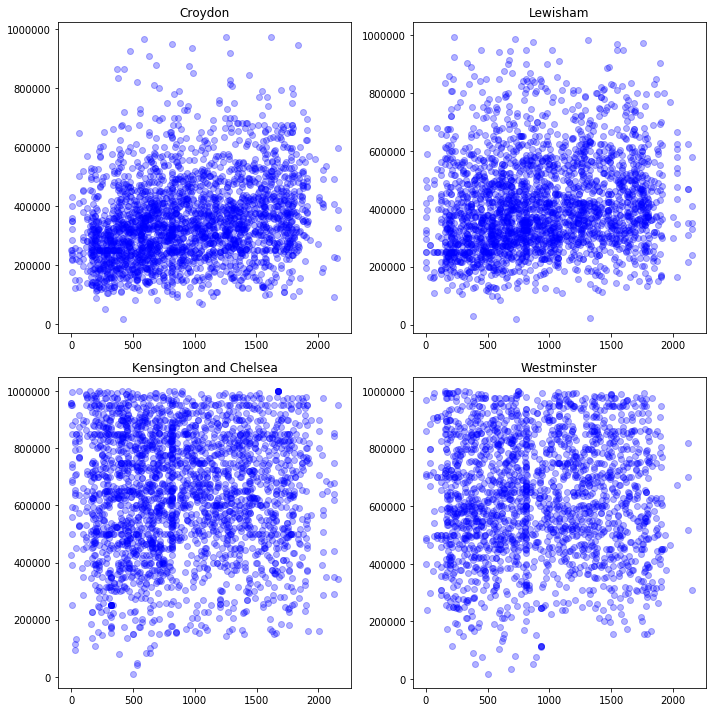

In [12]:
fig, axs = plotty.subplots(2, 2, figsize=(10, 10))
d = croydon_prep
axs[0, 0].scatter(d['days_since'], d['price_paid'], color='blue', alpha=0.3)
axs[0, 0].title.set_text('Croydon')
d = lewisham_prep
axs[0, 1].scatter(d['days_since'], d['price_paid'], color='blue', alpha=0.3)
axs[0, 1].title.set_text('Lewisham')
d = kensington_chelsea_prep
axs[1, 0].scatter(d['days_since'], d['price_paid'], color='blue', alpha=0.3)
axs[1, 0].title.set_text('Kensington and Chelsea')
d = westminster_prep
axs[1, 1].scatter(d['days_since'], d['price_paid'], color='blue', alpha=0.3)
axs[1, 1].title.set_text('Westminster')
fig.tight_layout()
plotty.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13e703438>,
      dtype=object)

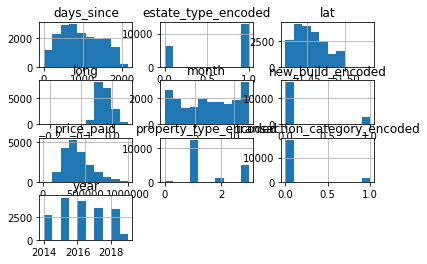

In [13]:
df.hist()

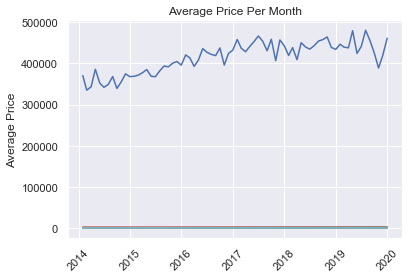

In [14]:
import seaborn as sns
sns.set()
df = df.resample('M').mean()
plotty.plot(df)
plotty.title('Average Price Per Month')
plotty.ylabel('Average Price')
plotty.xticks(rotation=45)
plotty.show()

# Modelling

## Croydon

In [20]:
df = croydon_prep
# Split data into predictors X and output Y
predictors = ['lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']
X = df[predictors]
y = df['price_paid']
# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
models = []

models.append(('LR', LinearRegression()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('XGB', XGBRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('GPR', GaussianProcessRegressor()))
models.append(('PER', Perceptron()))

# evaluate each model in turn
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    # Evaluate the performance of the algorithm with metrics
    # Mean Absolute Error
    mae = metrics.mean_absolute_error(y_test, y_pred)
    # Mean Squared Error
    mse = metrics.mean_squared_error(y_test, y_pred)
    # Root Mean Squared Error
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    msg = "%s: %f, mae: %f, mse: %f, rmse: %f" % (name, score, mae, mse, rmse)
    print(msg)

LR: 0.610153, mae: 66188.420715, mse: 8859682778.834406, rmse: 94125.887931
DTR: 0.436202, mae: 81709.688000, mse: 12812898145.915361, rmse: 113194.072927
[01:51:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB: 0.670914, mae: 59317.668094, mse: 7478818724.192115, rmse: 86480.163761
RFR: 0.666723, mae: 61275.636633, mse: 7574069948.719271, rmse: 87029.132759
GPR: -2.838947, mae: 186254.221696, mse: 87244038385.817184, rmse: 295371.018189
PER: 0.006000, mae: 166775.354000, mse: 38116224330.622002, rmse: 195233.768418


In [21]:
df = lewisham_prep
# Split data into predictors X and output Y
predictors = ['lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']
X = df[predictors]
y = df['price_paid']
# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
models = []

models.append(('LR', LinearRegression()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('XGB', XGBRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('GPR', GaussianProcessRegressor()))
models.append(('PER', Perceptron()))

# evaluate each model in turn
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    # Evaluate the performance of the algorithm with metrics
    # Mean Absolute Error
    mae = metrics.mean_absolute_error(y_test, y_pred)
    # Mean Squared Error
    mse = metrics.mean_squared_error(y_test, y_pred)
    # Root Mean Squared Error
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    msg = "%s: %f, mae: %f, mse: %f, rmse: %f" % (name, score, mae, mse, rmse)
    print(msg)

LR: 0.455035, mae: 85271.457003, mse: 13077961790.333790, rmse: 114358.916532
DTR: 0.189902, mae: 100507.940500, mse: 19440578776.454235, rmse: 139429.475996
[01:51:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB: 0.536352, mae: 77028.896875, mse: 11126532791.045784, rmse: 105482.381425
RFR: 0.511957, mae: 80530.606291, mse: 11711959932.163664, rmse: 108221.808949
GPR: -11.362868, mae: 235822.280054, mse: 296681790406.080566, rmse: 544685.037803
PER: 0.012000, mae: 174003.774000, mse: 47554886148.241997, rmse: 218070.828283


In [22]:
df = kensington_chelsea_prep
# Split data into predictors X and output Y
predictors = ['lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']
X = df[predictors]
y = df['price_paid']
# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
models = []

models.append(('LR', LinearRegression()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('XGB', XGBRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('GPR', GaussianProcessRegressor()))
models.append(('PER', Perceptron()))

# evaluate each model in turn
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    # Evaluate the performance of the algorithm with metrics
    # Mean Absolute Error
    mae = metrics.mean_absolute_error(y_test, y_pred)
    # Mean Squared Error
    mse = metrics.mean_squared_error(y_test, y_pred)
    # Root Mean Squared Error
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    msg = "%s: %f, mae: %f, mse: %f, rmse: %f" % (name, score, mae, mse, rmse)
    print(msg)

LR: 0.041104, mae: 166244.400574, mse: 40197853385.171097, rmse: 200494.023315
DTR: -0.502072, mae: 194143.454333, mse: 62968332198.380058, rmse: 250934.916260
[01:51:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB: 0.120571, mae: 156658.863937, mse: 36866547830.921967, rmse: 192006.634862
RFR: 0.018013, mae: 162560.401627, mse: 41165854244.019234, rmse: 202893.701834
GPR: -12.941230, mae: 420349.779478, mse: 584430109747.880493, rmse: 764480.287351
PER: 0.004000, mae: 288728.536000, mse: 121943630858.940002, rmse: 349204.282418


In [23]:
df = westminster_prep
# Split data into predictors X and output Y
predictors = ['lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']
X = df[predictors]
y = df['price_paid']
# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
models = []

models.append(('LR', LinearRegression()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('XGB', XGBRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('GPR', GaussianProcessRegressor()))
models.append(('PER', Perceptron()))

# evaluate each model in turn
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    # Evaluate the performance of the algorithm with metrics
    # Mean Absolute Error
    mae = metrics.mean_absolute_error(y_test, y_pred)
    # Mean Squared Error
    mse = metrics.mean_squared_error(y_test, y_pred)
    # Root Mean Squared Error
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    msg = "%s: %f, mae: %f, mse: %f, rmse: %f" % (name, score, mae, mse, rmse)
    print(msg)

LR: 0.063155, mae: 167115.078988, mse: 40409108279.924278, rmse: 201020.168839
DTR: -0.629806, mae: 206426.211667, mse: 70298753564.806656, rmse: 265139.121151
[01:51:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB: 0.113793, mae: 158764.880469, mse: 38224956994.694405, rmse: 195512.037979
RFR: 0.061269, mae: 157126.893174, mse: 40490465687.301369, rmse: 201222.428390
GPR: -13.365226, mae: 421464.140460, mse: 619618119516.923706, rmse: 787158.255700
PER: 0.000000, mae: 236186.607500, mse: 79931892069.092499, rmse: 282722.287889


# Optimising Models

In [24]:
df = croydon_prep
# Split data into predictors X and output Y
predictors = ['lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']
X = df[predictors]
y = df['price_paid']
# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
models = []

models.append(('LR', LinearRegression()))
models.append(('XGB', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)))
models.append(('RFR', RandomForestRegressor(n_estimators=40, n_jobs=-1)))

# evaluate each model in turn
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    # Evaluate the performance of the algorithm with metrics
    # Mean Absolute Error
    mae = metrics.mean_absolute_error(y_test, y_pred)
    # Mean Squared Error
    mse = metrics.mean_squared_error(y_test, y_pred)
    # Root Mean Squared Error
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    msg = "%s: %f, mae: %f, mse: %f, rmse: %f" % (name, score, mae, mse, rmse)
    print(msg)

LR: 0.610153, mae: 66188.420715, mse: 8859682778.834406, rmse: 94125.887931
XGB: 0.687116, mae: 58260.260062, mse: 7110617565.190571, rmse: 84324.477853
RFR: 0.681393, mae: 59528.590133, mse: 7240666506.159117, rmse: 85092.106016


In [25]:
df = lewisham_prep
# Split data into predictors X and output Y
predictors = ['lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']
X = df[predictors]
y = df['price_paid']
# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
models = []

models.append(('LR', LinearRegression()))
models.append(('XGB', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)))
models.append(('RFR', RandomForestRegressor(n_estimators=40, n_jobs=-1)))

# evaluate each model in turn
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    # Evaluate the performance of the algorithm with metrics
    # Mean Absolute Error
    mae = metrics.mean_absolute_error(y_test, y_pred)
    # Mean Squared Error
    mse = metrics.mean_squared_error(y_test, y_pred)
    # Root Mean Squared Error
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    msg = "%s: %f, mae: %f, mse: %f, rmse: %f" % (name, score, mae, mse, rmse)
    print(msg)

LR: 0.455035, mae: 85271.457003, mse: 13077961790.333790, rmse: 114358.916532
XGB: 0.537671, mae: 77489.838250, mse: 11094873726.425777, rmse: 105332.206501
RFR: 0.511949, mae: 79788.573646, mse: 11712153133.476933, rmse: 108222.701562


In [26]:
df = kensington_chelsea_prep
# Split data into predictors X and output Y
predictors = ['lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']
X = df[predictors]
y = df['price_paid']
# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
models = []

models.append(('LR', LinearRegression()))
models.append(('XGB', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)))
models.append(('RFR', RandomForestRegressor(n_estimators=40, n_jobs=-1)))

# evaluate each model in turn
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    # Evaluate the performance of the algorithm with metrics
    # Mean Absolute Error
    mae = metrics.mean_absolute_error(y_test, y_pred)
    # Mean Squared Error
    mse = metrics.mean_squared_error(y_test, y_pred)
    # Root Mean Squared Error
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    msg = "%s: %f, mae: %f, mse: %f, rmse: %f" % (name, score, mae, mse, rmse)
    print(msg)

LR: 0.041104, mae: 166244.400574, mse: 40197853385.171097, rmse: 200494.023315
XGB: 0.125444, mae: 150479.512187, mse: 36662236636.243294, rmse: 191473.853662
RFR: 0.070143, mae: 157470.336970, mse: 38980526087.295883, rmse: 197434.865430


In [27]:
df = westminster_prep
# Split data into predictors X and output Y
predictors = ['lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']
X = df[predictors]
y = df['price_paid']
# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
models = []

models.append(('LR', LinearRegression()))
models.append(('XGB', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)))
models.append(('RFR', RandomForestRegressor(n_estimators=40, n_jobs=-1)))

# evaluate each model in turn
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    # Evaluate the performance of the algorithm with metrics
    # Mean Absolute Error
    mae = metrics.mean_absolute_error(y_test, y_pred)
    # Mean Squared Error
    mse = metrics.mean_squared_error(y_test, y_pred)
    # Root Mean Squared Error
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    msg = "%s: %f, mae: %f, mse: %f, rmse: %f" % (name, score, mae, mse, rmse)
    print(msg)

LR: 0.063155, mae: 167115.078988, mse: 40409108279.924278, rmse: 201020.168839
XGB: 0.110669, mae: 154762.088164, mse: 38359694930.821648, rmse: 195856.311950
RFR: 0.088742, mae: 156169.397085, mse: 39305475620.791794, rmse: 198256.085962
